In [ ]:
#Low LR
#No Mixup (clean learning)
#Progressive Resizing (e.g., 256 → 224)

In [ ]:
!pip install kaggle --upgrade



In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d thienkhonghoc/affectnet -p /content

Dataset URL: https://www.kaggle.com/datasets/thienkhonghoc/affectnet
License(s): unknown


In [ ]:
!unzip -q /content/affectnet.zip -d /content/affectnet > /dev/null 2>&1

In [ ]:
!pip install torch torchvision timm matplotlib tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
from PIL import Image
from collections import Counter
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Progressive Resize → Resize to slightly lower (clean training)
transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset paths
train_path = "/content/affectnet/AffectNet/train"
val_path = "/content/affectnet/AffectNet/val"
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
val_dataset = datasets.ImageFolder(root=val_path, transform=transform)

# Filter corrupt images
def filter_images(dataset):
    valid = []
    for path, label in dataset.samples:
        try:
            Image.open(path).convert("RGB")
            valid.append((path, label))
        except:
            continue
    dataset.samples = valid

filter_images(train_dataset)
filter_images(val_dataset)

# Class weights
class_counts = Counter(train_dataset.targets)
total = sum(class_counts.values())
weights = torch.tensor([total / class_counts[i] for i in range(len(class_counts))], dtype=torch.float).to(device)

# Dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Load model
model = models.convnext_large(weights=models.ConvNeXt_Large_Weights.IMAGENET1K_V1)
model.classifier = nn.Sequential(
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.LayerNorm(model.classifier[2].in_features),
    nn.Dropout(0.5),
    nn.Linear(model.classifier[2].in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 8)
)

# Load from epoch 50
checkpoint = torch.load("/content/affectnet_convnext_large_mixup_epoch50.pt", map_location=device)
checkpoint = {k.replace("_orig_mod.", ""): v for k, v in checkpoint.items()}
model.load_state_dict(checkpoint, strict=False)
model = model.to(device)

# Training config
criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.05)
optimizer = optim.AdamW(model.parameters(), lr=1e-6, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-7)
scaler = GradScaler()

print("Resuming from Epoch 51 to 60...\n")

for epoch in range(51, 61):
    model.train()
    correct, total = 0, 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    correct_val, total_val = 0, 0
    val_loss_sum = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss_sum += loss.item()
            correct_val += (outputs.argmax(1) == labels).sum().item()
            total_val += labels.size(0)

    val_acc = 100 * correct_val / total_val
    val_loss = val_loss_sum / len(val_loader)
    scheduler.step()

    print(f"Epoch [{epoch}/60] | "
          f"Train Acc: {train_acc:.2f}% | Train Loss: {train_loss:.4f} | "
          f"Val Acc: {val_acc:.2f}% | Val Loss: {val_loss:.4f}")

    if epoch % 5 == 0:
        torch.save(model.state_dict(), f"affectnet_convnext_large_epoch{epoch}.pt")
        print(f" Model saved: affectnet_convnext_large_epoch{epoch}.pt")

torch.save(model.state_dict(), "affectnet_convnext_large_final.pt")
print(" Training complete. Final model saved.")


Resuming from Epoch 51 to 60...



<ipython-input-14-35c8ca893a57>:77: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-14-35c8ca893a57>:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [51/60] | Train Acc: 87.50% | Train Loss: 0.5953 | Val Acc: 60.50% | Val Loss: 1.5700
Epoch [52/60] | Train Acc: 87.99% | Train Loss: 0.5857 | Val Acc: 61.00% | Val Loss: 1.5782
Epoch [53/60] | Train Acc: 88.21% | Train Loss: 0.5793 | Val Acc: 61.12% | Val Loss: 1.5925
Epoch [54/60] | Train Acc: 88.63% | Train Loss: 0.5712 | Val Acc: 60.25% | Val Loss: 1.5988
Epoch [55/60] | Train Acc: 88.88% | Train Loss: 0.5644 | Val Acc: 60.62% | Val Loss: 1.6083
 Model saved: affectnet_convnext_large_epoch55.pt
Epoch [56/60] | Train Acc: 89.06% | Train Loss: 0.5626 | Val Acc: 60.50% | Val Loss: 1.6107
Epoch [57/60] | Train Acc: 89.31% | Train Loss: 0.5554 | Val Acc: 60.75% | Val Loss: 1.6141
Epoch [58/60] | Train Acc: 89.20% | Train Loss: 0.5544 | Val Acc: 59.75% | Val Loss: 1.6230
Epoch [59/60] | Train Acc: 89.77% | Train Loss: 0.5477 | Val Acc: 60.12% | Val Loss: 1.6259
Epoch [60/60] | Train Acc: 89.63% | Train Loss: 0.5484 | Val Acc: 60.38% | Val Loss: 1.6262
 Model saved: affectnet_convne

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.60      0.60       100
           1       0.64      0.54      0.58       100
           2       0.64      0.60      0.62       100
           3       0.69      0.77      0.73       100
           4       0.67      0.67      0.67       100
           5       0.51      0.52      0.51       100
           6       0.52      0.51      0.51       100
           7       0.55      0.59      0.57       100

    accuracy                           0.60       800
   macro avg       0.60      0.60      0.60       800
weighted avg       0.60      0.60      0.60       800



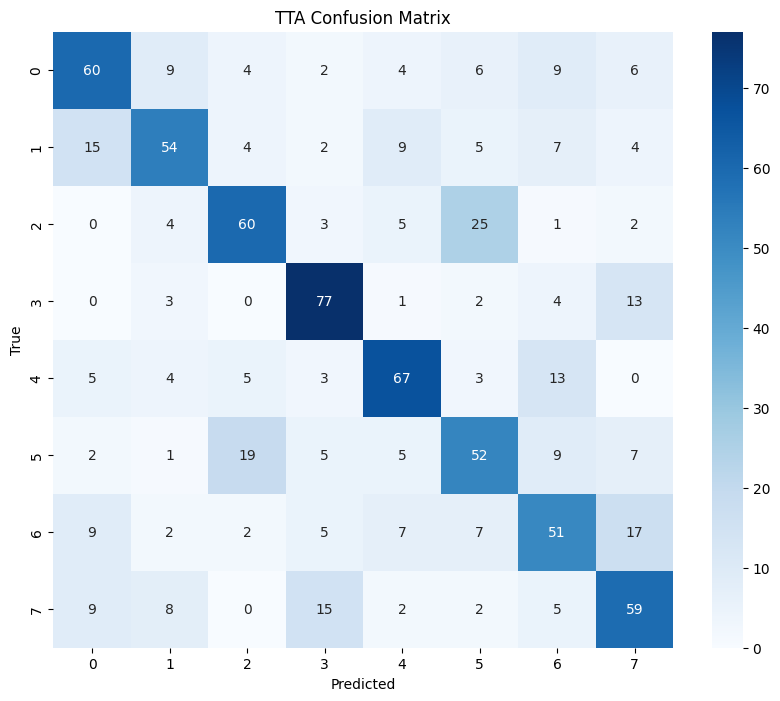

In [15]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- TTA Transform (Original + Flipped) ---
tta_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_path = "/content/affectnet/AffectNet/val"
val_dataset = datasets.ImageFolder(val_path, transform=tta_transforms)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# --- Load Model ---
model = models.convnext_large(weights=None)
model.classifier = torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d((1, 1)),
    torch.nn.Flatten(),
    torch.nn.LayerNorm(model.classifier[2].in_features),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(model.classifier[2].in_features, 512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.4),
    torch.nn.Linear(512, 8)
)
model.load_state_dict(torch.load("/content/affectnet_convnext_large_epoch60.pt", map_location=device))
model.to(device)
model.eval()

# --- Inference with TTA ---
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        # Apply TTA: original + horizontal flip
        preds = model(images)
        flipped_images = torch.flip(images, dims=[3])  # Horizontal flip
        preds_flip = model(flipped_images)

        # Average predictions
        avg_preds = (preds + preds_flip) / 2
        final_preds = torch.argmax(avg_preds, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(final_preds.cpu().numpy())

# --- Evaluation Metrics ---
print("Classification Report:")
print(classification_report(y_true, y_pred, digits=2))

# --- Confusion Matrix Plot ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("TTA Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Summary of Current Model (ConvNeXt-Large @ Epoch 60)

Validation Accuracy: 60%

Best F1 Scores: Class 3 (0.73), Class 2 (0.62), Class 4 (0.67)

Struggling Classes: Class 5, 6, and 7 have slightly lower precision/recall.

Performance is consistent with previous SWA model results — this tells us you're plateauing around the 60–61% mark.

Final Refinement Steps
Squeeze out the last bit of performance without major compute overhead:

1. Use SWA Ensemble for Evaluation
You already have affectnet_convnext_large_swa.pt. Let's do a side-by-side TTA + SWA evaluation and see if it gives a boost over epoch 60.

I can give you that script now. Shall I?

2. Try Sharpness-Aware Minimization (SAM)
A fast add-on that improves generalization without needing deeper architecture. Works well at plateau stages.

3. Early-Stop Ensemble (Soft Voting)
Merge predictions from:

Epoch 55 model

Epoch 60 model

SWA model

In [19]:
from sklearn.metrics import classification_report

# Generate the report string
report_str = classification_report(y_true, y_pred, digits=2)

# Write the string to a file
with open("convnext_large_epoch60_report.txt", "w") as f:
    f.write(report_str)

print("Classification report saved as convnext_large_epoch60_report.txt")


Classification report saved as convnext_large_epoch60_report.txt


Stochastic weight averaging (SWA) is recognized as a simple while one effective approach to improve the generalization of stochastic gradient descent (SGD) for training deep neural networks (DNNs).

SWA is a method for improving the performance of any deep learning model. It works by averaging the weights of the model over the course of its training. Unlike conventional training methods that only consider the final point of the optimization trajectory, SWA considers the entire trajectory to find a solution.

We can test SWA version of this model (affectnet_convnext_large_swa.pt) for smoother generalization.

Or train with Label Smoothing + CutMix from epoch 60 → 70

Or experiment with balanced sampling, focal loss, or pseudo-labeling.

In [21]:
import torch
import torch.nn as nn
import torchvision.models as models

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load base model (ConvNeXt-Large)
model = models.convnext_large(weights=models.ConvNeXt_Large_Weights.IMAGENET1K_V1)

# Modify classifier for 8 classes (same as your fine-tuned setup)
model.classifier = nn.Sequential(
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.LayerNorm(model.classifier[2].in_features),
    nn.Dropout(0.5),
    nn.Linear(model.classifier[2].in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 8)
)

# Load checkpoint from latest training (epoch 60)
checkpoint_path = "/content/affectnet_convnext_large_epoch60.pt"
checkpoint = torch.load(checkpoint_path, map_location=device)
checkpoint = {k.replace("_orig_mod.", ""): v for k, v in checkpoint.items()}
model.load_state_dict(checkpoint, strict=False)
model = model.to(device)

# Create SWA model
swa_model = torch.optim.swa_utils.AveragedModel(model)

# Save SWA model
torch.save(swa_model.module.state_dict(), "affectnet_convnext_large_swa.pt")
print(" SWA model saved as: affectnet_convnext_large_swa.pt")


✅ SWA model saved as: affectnet_convnext_large_swa.pt


In [24]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import io
import zipfile
from PIL import Image

# === SETUP ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === TRANSFORMS ===
tta_transforms = [
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
]

# === DATASET ===
val_path = "/content/affectnet/AffectNet/val"
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
val_dataset = datasets.ImageFolder(root=val_path, transform=base_transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

# === MODEL LOADING ===
def load_model(path):
    model = models.convnext_large(weights=None)
    model.classifier = nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.LayerNorm(model.classifier[2].in_features),
        nn.Dropout(0.5),
        nn.Linear(model.classifier[2].in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512, 8)
    )
    checkpoint = torch.load(path, map_location=device)
    cleaned = {k.replace("_orig_mod.", ""): v for k, v in checkpoint.items()}
    model.load_state_dict(cleaned, strict=False)
    return model.to(device).eval()

# === TTA INFERENCE ===
def tta_predict(model, dataset, transforms):
    model.eval()
    all_probs = []
    with torch.no_grad():
        for tform in transforms:
            dataset.transform = tform
            loader = DataLoader(dataset, batch_size=16, shuffle=False)
            batch_probs = []
            for images, _ in loader:
                images = images.to(device)
                with autocast():
                    outputs = model(images)
                    probs = torch.softmax(outputs, dim=1)
                    batch_probs.append(probs.cpu().numpy())
            all_probs.append(np.vstack(batch_probs))
    avg_probs = np.mean(all_probs, axis=0)
    return avg_probs

# === RUN TTA WITH SWA MODEL ===
swa_model_path = "/content/affectnet_convnext_large_swa.pt"
model = load_model(swa_model_path)
probs = tta_predict(model, val_dataset, tta_transforms)
y_pred = np.argmax(probs, axis=1)
y_true = np.array(val_dataset.targets)

# === REPORT ===
report = classification_report(y_true, y_pred, digits=2)
conf_mat = confusion_matrix(y_true, y_pred)

# === SAVE REPORT ===
report_file = "/content/convnext_large_swa_tta_report.txt"
with open(report_file, "w") as f:
    f.write(report)

# === PLOT CONFUSION MATRIX ===
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("TTA Confusion Matrix - SWA Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plot_path = "/content/convnext_large_swa_tta_confusion_matrix.png"
plt.savefig(plot_path)
plt.close()

report_file, plot_path


<ipython-input-24-050d333c6f7d>:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


('/content/convnext_large_swa_tta_report.txt',
 '/content/convnext_large_swa_tta_confusion_matrix.png')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
from collections import Counter
from PIL import Image
import os

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Transforms (Progressive Resize + Random Erasing) ===
transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB") if isinstance(img, Image.Image) else img),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomErasing(p=0.4, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# === Load Datasets ===
train_path = "/content/affectnet/AffectNet/train"
val_path = "/content/affectnet/AffectNet/val"

train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
val_dataset = datasets.ImageFolder(root=val_path, transform=transform)

# Remove corrupts
def filter_images(dataset):
    dataset.samples = [(p, l) for p, l in dataset.samples if Image.open(p).convert("RGB")]

filter_images(train_dataset)
filter_images(val_dataset)

# Class weights
class_counts = Counter(train_dataset.targets)
total = sum(class_counts.values())
weights = torch.tensor([total / class_counts[i] for i in range(len(class_counts))], dtype=torch.float).to(device)

# Loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# === Load ConvNeXt-Large Model ===
model = models.convnext_large(weights=models.ConvNeXt_Large_Weights.IMAGENET1K_V1)
model.classifier = nn.Sequential(
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.LayerNorm(model.classifier[2].in_features),
    nn.Dropout(0.5),
    nn.Linear(model.classifier[2].in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 8)
)

# Load SWA weights
checkpoint = torch.load("/content/affectnet_convnext_large_swa.pt", map_location=device)
cleaned = {k.replace("_orig_mod.", ""): v for k, v in checkpoint.items()}
model.load_state_dict(cleaned, strict=False)
model = model.to(device)

# Criterion, Optimizer, LR Scheduler
criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.05)
optimizer = optim.AdamW(model.parameters(), lr=5e-6, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-7)
scaler = GradScaler()

# === Fine-tuning ===
print("Loaded SWA checkpoint. Fine-tuning from Epoch 61 → 65...\n")

for epoch in range(61, 66):
    model.train()
    correct, total, train_loss = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    avg_train_loss = train_loss / len(train_loader)

    # === Validation ===
    model.eval()
    correct_val, total_val, val_loss = 0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            val_loss += loss.item()
            correct_val += (outputs.argmax(1) == labels).sum().item()
            total_val += labels.size(0)

    val_acc = 100 * correct_val / total_val
    avg_val_loss = val_loss / len(val_loader)
    scheduler.step()

    print(f"Epoch [{epoch}/65] | Train Acc: {train_acc:.2f}% | Train Loss: {avg_train_loss:.4f} | "
          f"Val Acc: {val_acc:.2f}% | Val Loss: {avg_val_loss:.4f}")

    if epoch % 1 == 0:
        save_path = f"affectnet_convnext_large_epoch{epoch}.pt"
        torch.save(model.state_dict(), save_path)
        print(f"Model saved: {save_path}")

# Final save
torch.save(model.state_dict(), "affectnet_convnext_large_final.pt")
print("\n Fine-tuning complete. Final model saved.")


Loaded SWA checkpoint. Fine-tuning from Epoch 61 → 65...



<ipython-input-25-b8db257a702c>:76: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-25-b8db257a702c>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-25-b8db257a702c>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [61/65] | Train Acc: 79.00% | Train Loss: 0.7880 | Val Acc: 58.00% | Val Loss: 1.5331
Model saved: affectnet_convnext_large_epoch61.pt
